# Dataset stats

Here, we examine a simulated dataset of ca. 181000 circuits and analyse its basic characteristics.

## Background

A large set of randomly generated RNA circuits was first created as a starting point and the binding energies of all RNAs were determined by the RNA simulator. This list of circuits was then filtered for circuits with a minimum number of 2 interacting species and at least 1 self interacting specie. From these, the first 1000 circuits were chosen as reference circuits. Each was then initialised with a set of mutated versions of itself, where each species was mutated at one of [1, 2, 3, 5, 10, 15] locations on its strand, with 10 variations in total. A reference circuit would thereby have a total of 3 (number of species) * 10 (variations) * 6 (number of mutations within a sequence) = 180 mutated subcircuits. 

Once all the circuits have been determined, their function must be determined. This involved first finding the steady state of the unbound and bound RNA species, then simulating the behavior of the circuit upon being perturbed by a step function. In this case, the step signal was a 2x increase in the species 'RNA_0', which happens instantaneously. In a lab experiment, there are many different ways of implementing this, each with a different delay, so the instantaneous increase presents the most extreme case.

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sns.histplot = partial(sns.histplot, palette=sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1))
pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


# import umap
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from bioreaction.simulation.manager import simulate_steady_states
from bioreaction.simulation.simfuncs.basic_de import bioreaction_sim_expanded
from src.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from src.utils.misc.helper import vanilla_return
from src.utils.misc.numerical import count_monotonic_group_lengths, find_monotonic_group_idxs, is_within_range
from src.utils.misc.string_handling import string_to_tuple_list
from src.utils.misc.type_handling import flatten_listlike, get_first_elements
from src.utils.misc.string_handling import prettify_keys_for_label
from src.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from src.utils.results.analytics.timeseries import generate_analytics
from tests_local.shared import CONFIG
from src.utils.common.setup_new import construct_circuit_from_cfg, prepare_config
from explanations.data_enhancing import enhance_data, proc_info, melt, summ

CONFIG = prepare_config(CONFIG)

In [3]:
og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'
fn_og = os.path.join(og_dir, 'circuit_stats.csv')
mut_dir = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/mutation_effect_on_interactions_signal'
fn_mut = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/summarise_simulation/tabulated_mutation_info.csv'


In [4]:
data_og = pd.read_csv(fn_og)

## Distribution of interactions

The minimum free energy (kcal) of binding between each pair of RNA molecules in the circuit is calculated by the RNA simulator. This is then converted into an equilibrium constant through a parameterisation function that was estimated from experimental data (see notebook on calculating binding energies / interactions).

naming.py:get_true_interaction_cols():87: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():87: Assuming that the number of species is 3 WARNING
naming.py:get_true_interaction_cols():87: Assuming that the number of species is 3 WARNING
/tmp/ipykernel_2969612/2259287696.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(dfm, x='energies', log_scale=[False, True], element='step')
/tmp/ipykernel_2969612/2259287696.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(dfm, x='binding_rates_dissociation', log_scale=[False, True], element='step', color='orange')
/tmp/ipykernel_2969612/2259287696.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(dfm, x='eqconstants', log_scale=[True, True], element='step', color='g')


Text(0.5, 0.98, 'Interaction distributions of\nsource dataset')

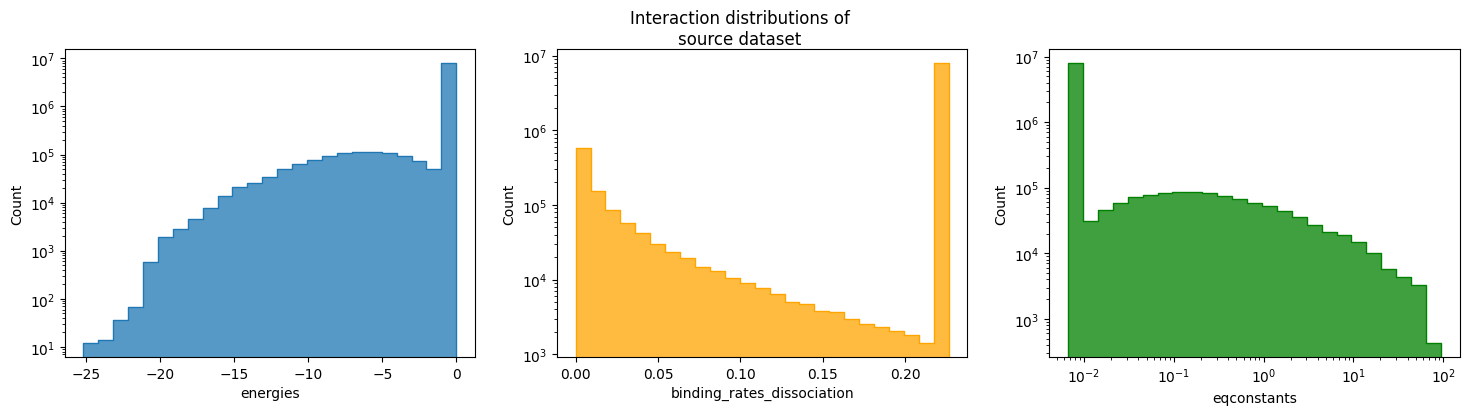

In [7]:
dfm = data_og.melt(['name'], get_true_interaction_cols(data_og, 'energies'), value_name='energies', var_name='idx')
dfm1 = data_og.melt(['name'], get_true_interaction_cols(data_og, 'binding_rates_dissociation'), value_name='binding_rates_dissociation', var_name='idx')
dfm['binding_rates_dissociation'] = dfm1['binding_rates_dissociation']
dfm1 = data_og.melt(['name'], get_true_interaction_cols(data_og, 'eqconstants'), value_name='eqconstants', var_name='idx')
dfm['eqconstants'] = dfm1['eqconstants']
del dfm1

plt.figure(figsize=(18,4))
ax = plt.subplot(1,3,1)
sns.histplot(dfm, x='energies', log_scale=[False, True], element='step')
ax = plt.subplot(1,3,2)
sns.histplot(dfm, x='binding_rates_dissociation', log_scale=[False, True], element='step', color='orange')
ax = plt.subplot(1,3,3)
sns.histplot(dfm, x='eqconstants', log_scale=[True, True], element='step', color='g')

plt.suptitle('Interaction distributions of\nsource dataset')

The distribution of interactions in the dataset that includes all mutations still matches that of the original dataset, from which the 1000 source circuits were chosen.

In [5]:
data = pd.read_csv(fn_mut)

Enrich some of the data columns

In [6]:
# data, datam, data_summ = enhance_data(data) 

data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/gene-circuit-glitch-prediction/explanations/data_enhancing.py:70: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  mutation_log = grouped[numerical_cols].apply(


In [11]:
# datam = melt(data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log)
# data_summ = summ(data, datam, bs_range_cols)

In [12]:
# E = dfm[dfm['mutation_name'] == 'ref_circuit']['energies'].min()
# E = np.array([0.0, -10.85, -23.83, -10.85, -5.36, 0.0, -23.83, 0.0, 0.0]).reshape(3, 3)

# Keq = np.array([[6.6701183e-03, 1.4914810e+00, 9.0059100e+01, 1.4914810e+00, 9.7195335e-02, 6.6701183e-03, 9.0059100e+01, 6.6701183e-03, 6.6701183e-03]]).reshape(3, 3)

# initial = np.array(sorted([r.quantity for r in circuits[0].qreactions.reactants if r.species in circuits[0].get_input_species()]))
# Fs = np.exp(-0.8 * (E + 10))
# Keq / Fs/initial

# # (Fs / Keq )[2,0]

/tmp/ipykernel_2969612/832521370.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(dfm[dfm['mutation_name'] == 'ref_circuit'], x='energies', log_scale=[False, True], element='step')
/tmp/ipykernel_2969612/832521370.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(dfm[dfm['mutation_name'] == 'ref_circuit'], x='binding_rates_dissociation', log_scale=[False, True], element='step', color='orange')
/tmp/ipykernel_2969612/832521370.py:19: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(dfm[dfm['mutation_name'] == 'ref_circuit'], x='eqconstants', log_scale=[True, True], element='step', color='g')
/tmp/ipykernel_2969612/832521370.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(dfm, x='energies', log_scale=[False, True], element='step')
/tmp/ipykernel_2969612/832521370.py:27: UserWarning: Ignoring `palet

Text(0.5, 0.98, 'Interaction distributions of simulated dataset')

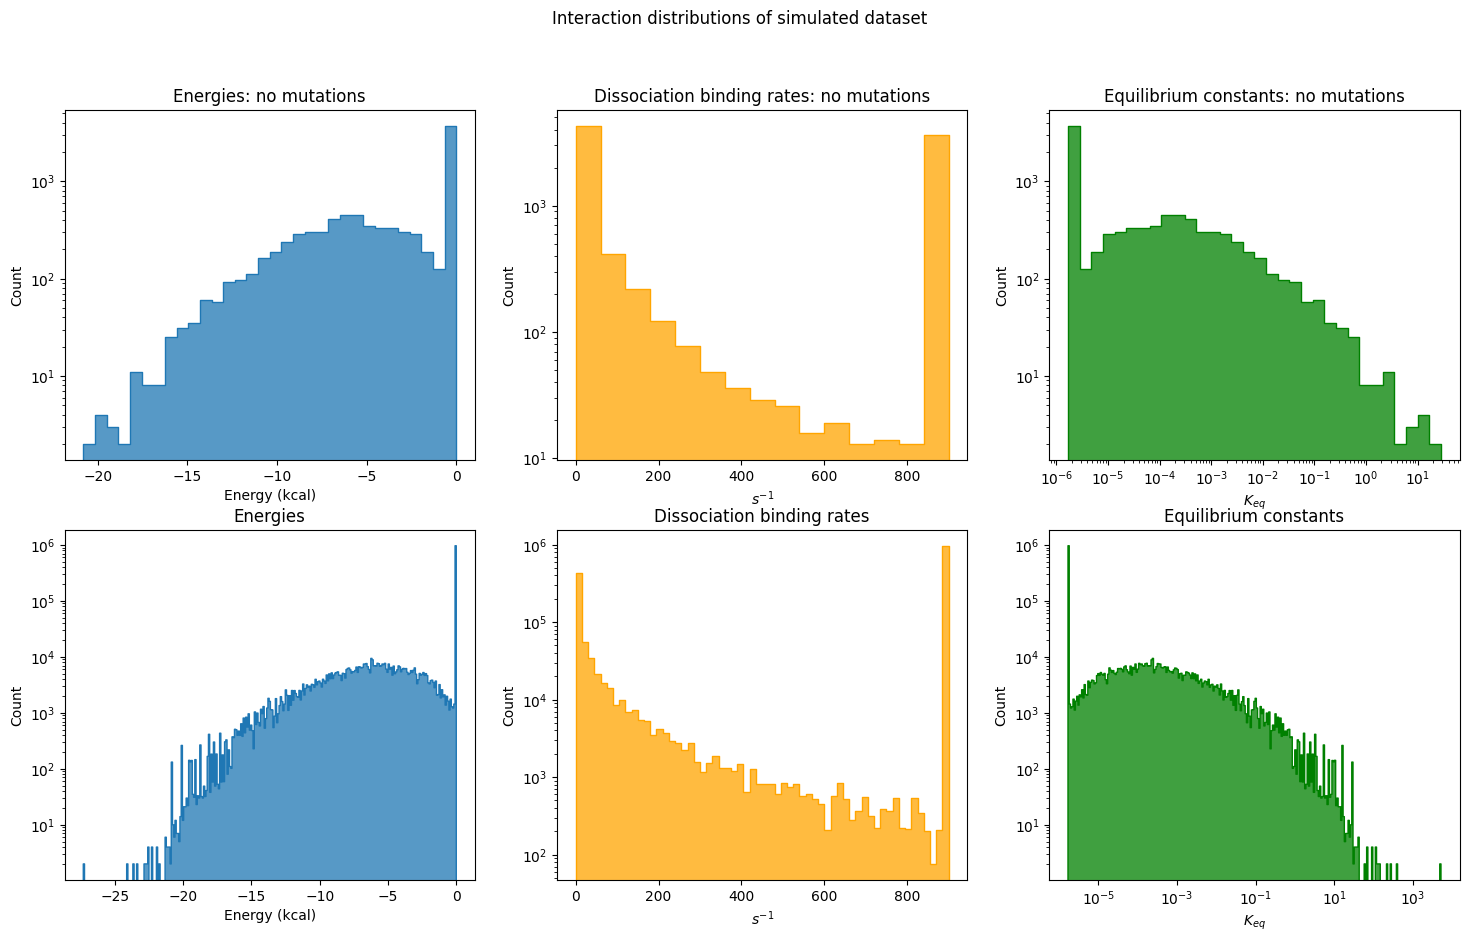

In [13]:
dfm = data[data['sample_name'] == 'RNA_0'].melt(['circuit_name', 'mutation_name'], get_true_interaction_cols(data, 'energies'), value_name='energies', var_name='idx')
dfm1 = data[data['sample_name'] == 'RNA_0'].melt(['circuit_name', 'mutation_name'], get_true_interaction_cols(data, 'binding_rates_dissociation'), value_name='binding_rates_dissociation', var_name='idx')
dfm['binding_rates_dissociation'] = dfm1['binding_rates_dissociation']
dfm1 = data[data['sample_name'] == 'RNA_0'].melt(['circuit_name', 'mutation_name'], get_true_interaction_cols(data, 'eqconstants'), value_name='eqconstants', var_name='idx')
dfm['eqconstants'] = dfm1['eqconstants']
del dfm1

plt.figure(figsize=(18,10))
ax = plt.subplot(2,3,1)
sns.histplot(dfm[dfm['mutation_name'] == 'ref_circuit'], x='energies', log_scale=[False, True], element='step')
plt.title('Energies: no mutations')
plt.xlabel('Energy (kcal)')
ax = plt.subplot(2,3,2)
sns.histplot(dfm[dfm['mutation_name'] == 'ref_circuit'], x='binding_rates_dissociation', log_scale=[False, True], element='step', color='orange')
plt.title('Dissociation binding rates: no mutations')
plt.xlabel('$s^{-1}$')
ax = plt.subplot(2,3,3)
plt.title('Equilibrium constants: no mutations')
sns.histplot(dfm[dfm['mutation_name'] == 'ref_circuit'], x='eqconstants', log_scale=[True, True], element='step', color='g')
plt.xlabel('$K_{eq}$')

ax = plt.subplot(2,3,4)
sns.histplot(dfm, x='energies', log_scale=[False, True], element='step')
plt.title('Energies')
plt.xlabel('Energy (kcal)')
ax = plt.subplot(2,3,5)
sns.histplot(dfm, x='binding_rates_dissociation', log_scale=[False, True], element='step', color='orange')
plt.title('Dissociation binding rates')
plt.xlabel('$s^{-1}$')
ax = plt.subplot(2,3,6)
sns.histplot(dfm, x='eqconstants', log_scale=[True, True], element='step', color='g')
plt.title('Equilibrium constants')
plt.xlabel('$K_{eq}$')

plt.suptitle('Interaction distributions of simulated dataset')

## Example trace of a circuit

Here is a demonstration of how a circuit's dynamics can be examined given some kind of input. In this case, the input is a step function of species `RNA_0`.

In [7]:
data[(data['sample_name'] == 'RNA_0') & (data['mutation_name'] == 'ref_circuit')]

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,name,interacting,self_interacting,num_interacting,...,sp_distance_logm,binding_sites_groups_0-0_logm,binding_sites_groups_0-1_logm,binding_sites_groups_0-2_logm,binding_sites_groups_1-0_logm,binding_sites_groups_1-1_logm,binding_sites_groups_1-2_logm,binding_sites_groups_2-0_logm,binding_sites_groups_2-1_logm,binding_sites_groups_2-2_logm
0,toy_circuit_combo0_100572,ref_circuit,0,[],[],NaN,toy_circuit_combo0_100572,[[0 2]\n [1 2]],[[2 2]],2,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
543,toy_circuit_combo0_10360,ref_circuit,0,[],[],NaN,toy_circuit_combo0_10360,[[0 1]\n [1 2]],[[0 0]],2,...,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1086,toy_circuit_combo0_104210,ref_circuit,0,[],[],NaN,toy_circuit_combo0_104210,[[0 1]\n [0 2]],[[0 0]],2,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
1629,toy_circuit_combo0_104799,ref_circuit,0,[],[],NaN,toy_circuit_combo0_104799,[[0 1]\n [0 2]],[[0 0]],2,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
2172,toy_circuit_combo0_105116,ref_circuit,0,[],[],NaN,toy_circuit_combo0_105116,[[0 1]\n [0 2]\n [1 2]],[[0 0]\n [1 1]\n [2 2]],3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540285,toy_circuit_combo0_996123,ref_circuit,0,[],[],NaN,toy_circuit_combo0_996123,[[0 2]\n [1 2]],[[2 2]],2,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0
540828,toy_circuit_combo0_997201,ref_circuit,0,[],[],NaN,toy_circuit_combo0_997201,[[0 1]\n [0 2]],[[0 0]],2,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
541371,toy_circuit_combo0_997282,ref_circuit,0,[],[],NaN,toy_circuit_combo0_997282,[[0 1]\n [0 2]],[[1 1]],2,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
541914,toy_circuit_combo0_998339,ref_circuit,0,[],[],NaN,toy_circuit_combo0_998339,[[0 2]\n [1 2]],[[1 1]\n [2 2]],2,...,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0


In [37]:
def load_circuit(circ_row, config):

    def symmetrical_matrix_length(flattened_length):
        return int((-1 + np.sqrt(1 + 8 * flattened_length)) / 2)

    def flatten_to_matrix(flattened_vector):
        length = symmetrical_matrix_length(len(flattened_vector))
        matrix = [[0] * length for _ in range(length)]

        index = 0
        for i in range(length):
            for j in range(i, length):
                matrix[i][j] = flattened_vector[index]
                matrix[j][i] = flattened_vector[index]
                index += 1

        return np.array(matrix)
    
    circ_path = os.path.join(og_dir, 'circuits', circ_row['name'] + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_rates_dissociation')]),
                    'eqconstants': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'eqconstants')]),
                    'energies': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'energies')]),
                    'binding_sites': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_sites')])}
    circuit = construct_circuit_from_cfg({
        'data_path': circ_path,
        'interactions': interactions
    }, config)
    circuit.subname = circ_row['mutation_name']
    return circuit
    

nm = 3
circuits = []
num_circuits = 3
for i in range(num_circuits):
    ref_c = data[(data['sample_name'] == 'RNA_0') & (data['mutation_name'] == 'ref_circuit')].iloc[i]
    mut_c = data[(data['sample_name'] == 'RNA_0') & (data['circuit_name'] == ref_c['circuit_name']) & (data['mutation_name'] != 'ref_circuit')].iloc[:nm]
    circuits.append(load_circuit(circ_row=ref_c, config=CONFIG))
    for mi in range(len(mut_c)):
        circuits.append(load_circuit(circ_row=mut_c.iloc[mi], config=CONFIG))
        

forward_rates = circuits[0].qreactions.reactions.forward_rates
reverse_rates = np.asarray(
    [c.qreactions.reactions.reverse_rates for c in circuits])


t0 = 0 
t1 = 200
dt = 0.001
tmax = 5000
threshold_steady_states = 0.005

signal_onehot = np.zeros_like(circuits[0].signal.reactions_onehot) if circuits[0].use_prod_and_deg else np.zeros_like(circuits[0].signal.onehot)
sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt,
                            signal=vanilla_return, signal_onehot=signal_onehot,
                            inputs=circuits[0].qreactions.reactions.inputs,
                            outputs=circuits[0].qreactions.reactions.outputs,
                            forward_rates=forward_rates,
                            solver=dfx.Tsit5(),
                            saveat=dfx.SaveAt(
                                ts=np.linspace(t0, t1, 1000))
                            )))


In [38]:

starting_states = np.asarray(
    [c.qreactions.quantities for c in circuits])
b_copynumbers, tss = simulate_steady_states(
    y0=starting_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=t1,
    threshold=threshold_steady_states, reverse_rates=reverse_rates)

b_copynumbers = np.swapaxes(b_copynumbers, 1, 2)


Done:  0:00:23.197078


In [39]:
signal_species_idx = 6

b_steady_states = b_copynumbers[:, :, -1]
b_steady_states[:, signal_species_idx] += b_copynumbers[:, signal_species_idx, 0]

b_new_copynumbers, tyy = simulate_steady_states(
    y0=b_steady_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=tss[-1],
    threshold=threshold_steady_states,
    reverse_rates=reverse_rates)

b_new_copynumbers = np.swapaxes(b_new_copynumbers, 1, 2)

Steady states:  200.0  iterations.  15  left to steady out.  0:00:21.570223
Done:  0:00:44.547178


In [40]:
b_new_copynumbers.shape

(12, 9, 2000)

(190.0, 210.0)

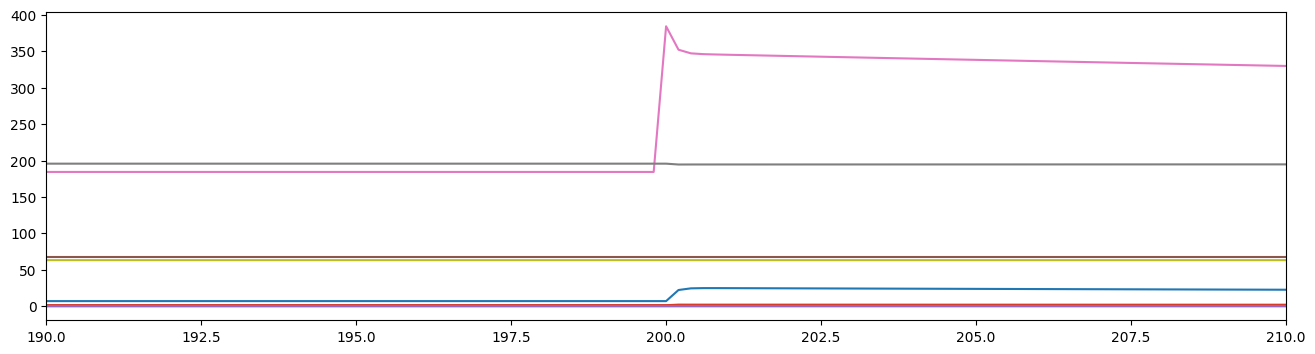

In [46]:
plt.figure(figsize=(16, 4))

i=6
plt.plot(np.concatenate([tss, tyy + tss[-1]]), np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T]))
plt.xlim([190, 210])

Text(0.5, 0.98, 'Circuit traces: reference and mutations')

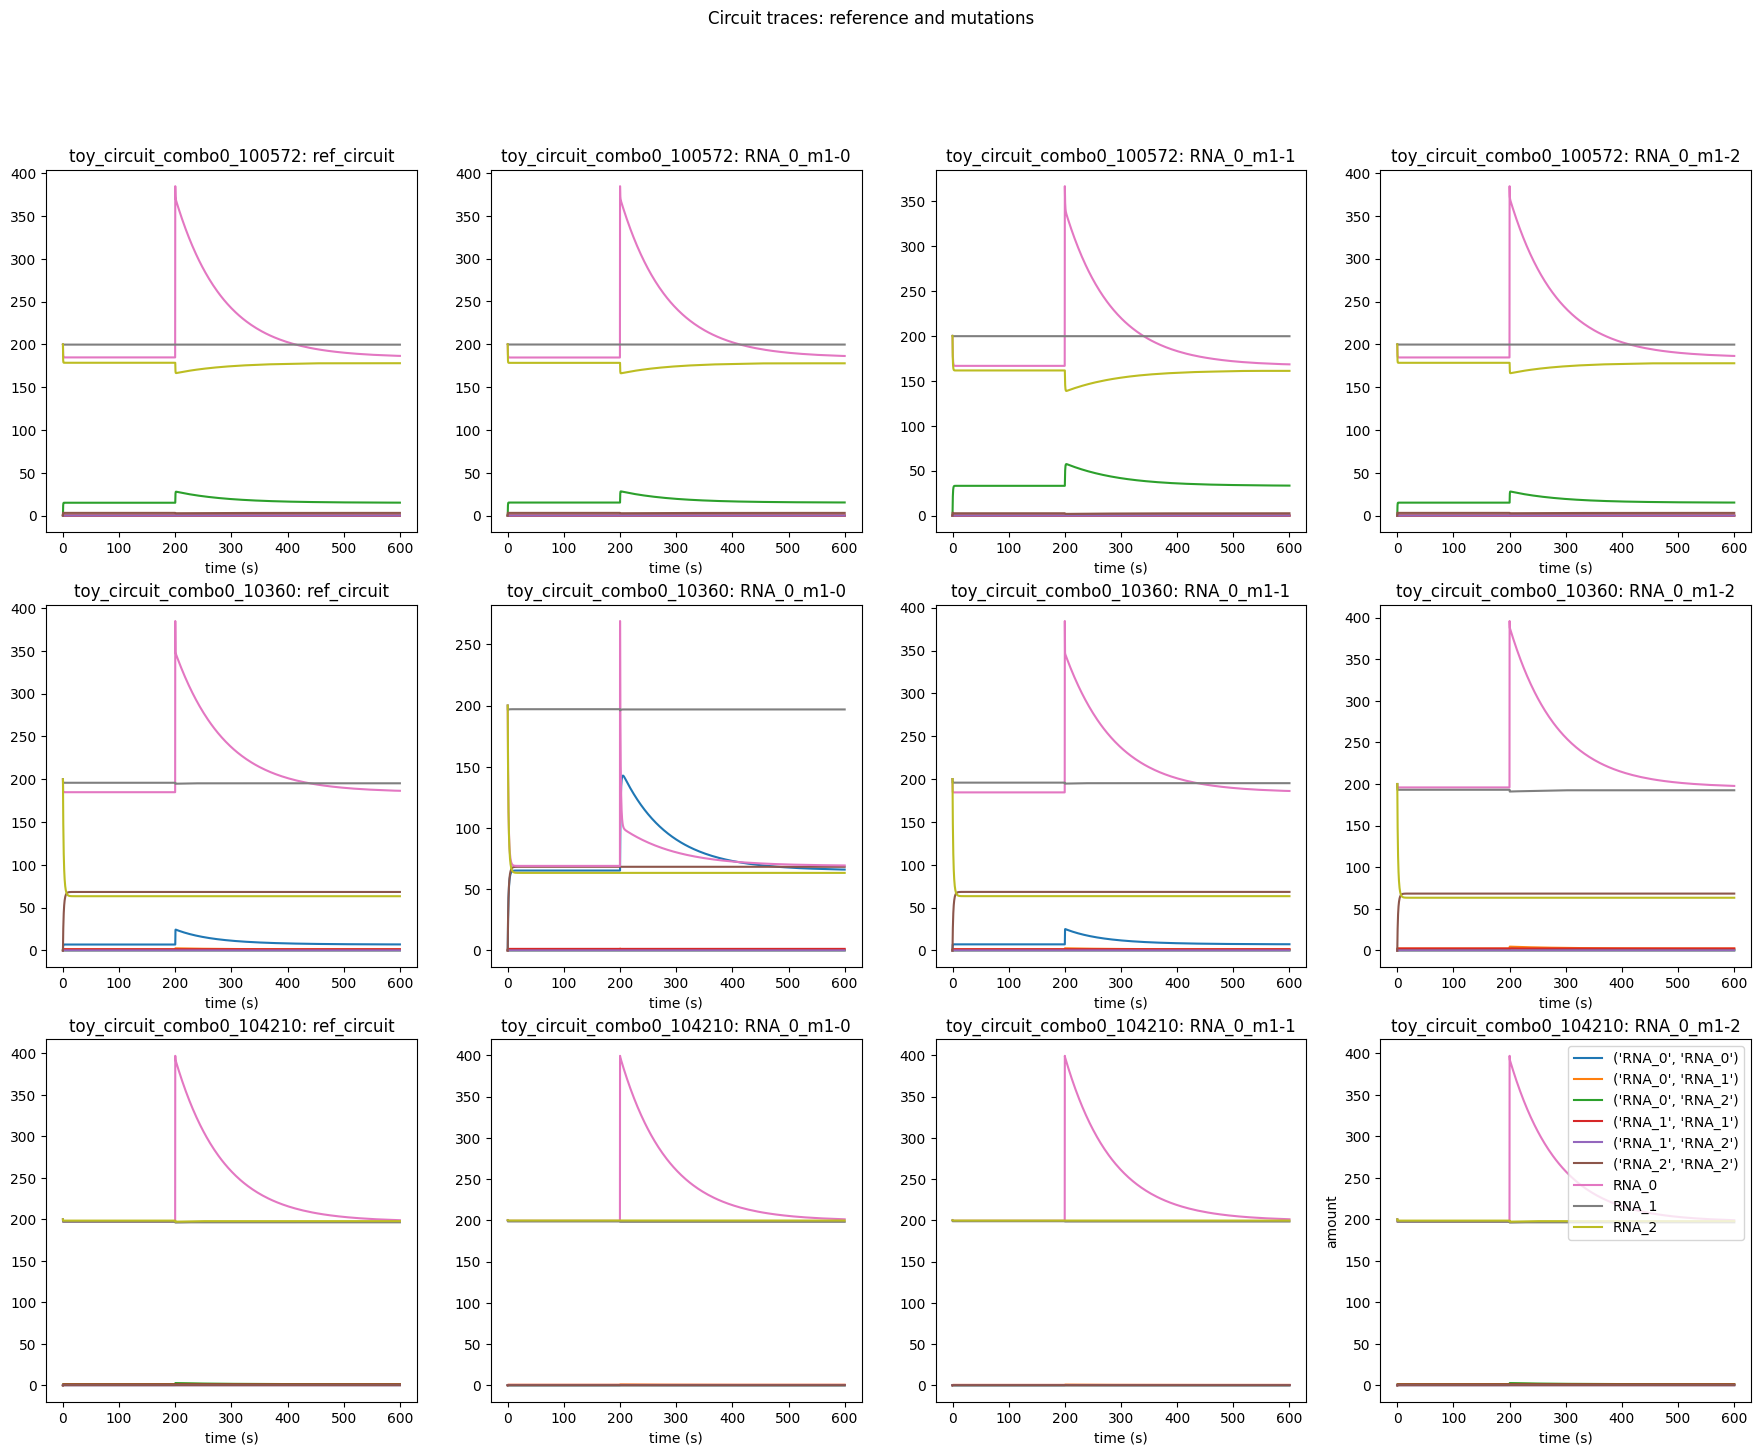

In [42]:
plt.figure(figsize=(22, 16))
for i in range(len(circuits)):
    ax = plt.subplot(num_circuits,nm+1,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]]), np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T]))
    plt.title(f'{circuits[i].name}: {circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
plt.ylabel('amount')

plt.suptitle('Circuit traces: reference and mutations')


In the trace above, the steady state of all species is simulated first, followed by the simulation of the step response. Many species have an overshoot before they settle into their new steady states. This and other features can be analysed. 

### Analytics from trace

In [19]:

def append_nest_dicts(l: list, i1: int, d: dict) -> list:
    for i in range(i1):
        b_analytics_k = {}
        for k, v in d.items():
            b_analytics_k[k] = v[i]
        l.append(b_analytics_k)
    return l
b_analytics_l = []
        
ref_idxs = [i for i, x in enumerate([c.subname for c in circuits]) if x == "ref_circuit"]
for ref_idx, ref_idx2 in zip(ref_idxs, ref_idxs[1:] + [len(circuits)]):
    ref_circuit = circuits[ref_idx]
    analytics_func = jax.vmap(partial(
        generate_analytics, time=tyy, labels=[
            s.name for s in ref_circuit.model.species],
        signal_onehot=ref_circuit.signal.onehot, signal_time=1))
    b_analytics = analytics_func(
        data=b_new_copynumbers[ref_idx:ref_idx2])
    
    b_analytics_l = append_nest_dicts(
        b_analytics_l, ref_idx2 - ref_idx, b_analytics)

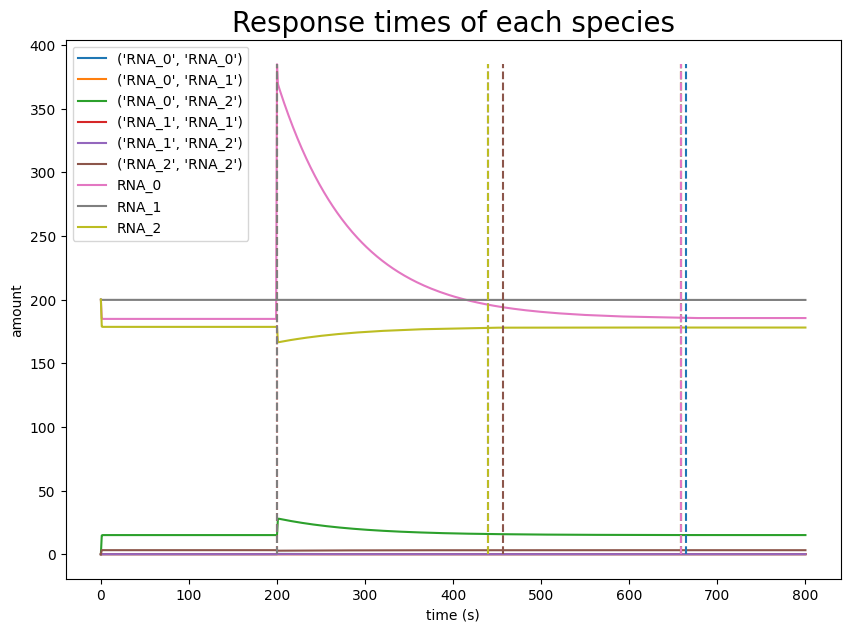

In [20]:
i = 0
plt.figure(figsize=(10, 7))
plt.gca().set_prop_cycle(None)
plt.plot(np.concatenate([tss, tyy + tss[-1]]), np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T]), )
plt.legend([s.name for s in circuits[0].model.species])
plt.xlabel('time (s)')
plt.ylabel('amount')
plt.title('Response times of each species', fontsize=20)

plt.gca().set_prop_cycle(None)
for s in range(len(circuits[0].model.species)):
    plt.plot(np.repeat(b_analytics_l[i]['response_time_wrt_species-6'], repeats=2, axis=1)[s] + t1, [0, np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T]).max()], '--')

The response times above are shown in a dotted line, with each color corresponding to each species.

Text(0.5, 0.98, 'Sensitivity vs. Precision')

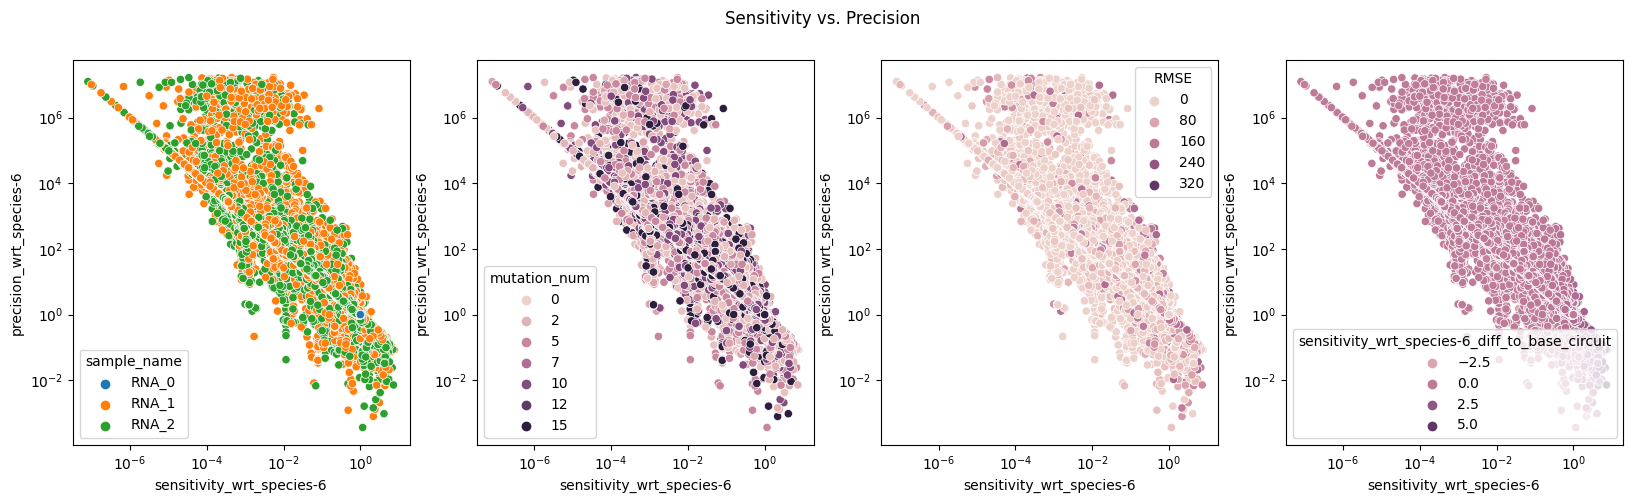

In [34]:
plt.figure(figsize=(20,5))
ax = plt.subplot(1,4,1)
sns.scatterplot(data, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='sample_name')
plt.xscale('log')
plt.yscale('log')
ax = plt.subplot(1,4,2)
sns.scatterplot(data, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='mutation_num')
plt.xscale('log')
plt.yscale('log')
ax = plt.subplot(1,4,3)
sns.scatterplot(data, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='RMSE')
plt.xscale('log')
plt.yscale('log')
ax = plt.subplot(1,4,4)
sns.scatterplot(data, x='sensitivity_wrt_species-6', y='precision_wrt_species-6', hue='sensitivity_wrt_species-6_diff_to_base_circuit')
plt.xscale('log')
plt.yscale('log')

plt.suptitle('Sensitivity vs. Precision')

## Mutation effect

We can see that characterising the function of each circuit is doable through its analytics. We can therefore assess the effects of a mutation on the function of each circuit by seeing how the analytics change. The variation of an analytic within a circuit family would reveal how sensitive each starting circuit is to mutation. 

In [20]:
# Mutation stats

good_cols = list(data.columns)
[good_cols.remove(x) for x in get_true_interaction_cols(data, 'binding_rates_dissociation') + get_true_interaction_cols(data, 'eqconstants') +
get_true_interaction_cols(data, 'energies') + get_true_interaction_cols(data, 'binding_sites') + num_group_cols + num_bs_cols]
# interaction = 'energies'
dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)
# dfm = data[data['sample_name'] == 'RNA_0'].melt(good_cols, value_vars=get_true_interaction_cols(
#     data, interaction), var_name='idx', value_name=interaction)

/home/wadh6511/Kode/gene-circuit-glitch-prediction/explanations/data_enhancing.py:121: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  infom[f'{k}_diffs'] = info.groupby(['circuit_name'])[get_true_interaction_cols2(info, k)].apply(
/home/wadh6511/Kode/gene-circuit-glitch-prediction/explanations/data_enhancing.py:123: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and

Distribution of energies by mutation number.

<AxesSubplot: xlabel='binding_rates_dissociation', ylabel='Count'>

<Figure size 640x480 with 0 Axes>

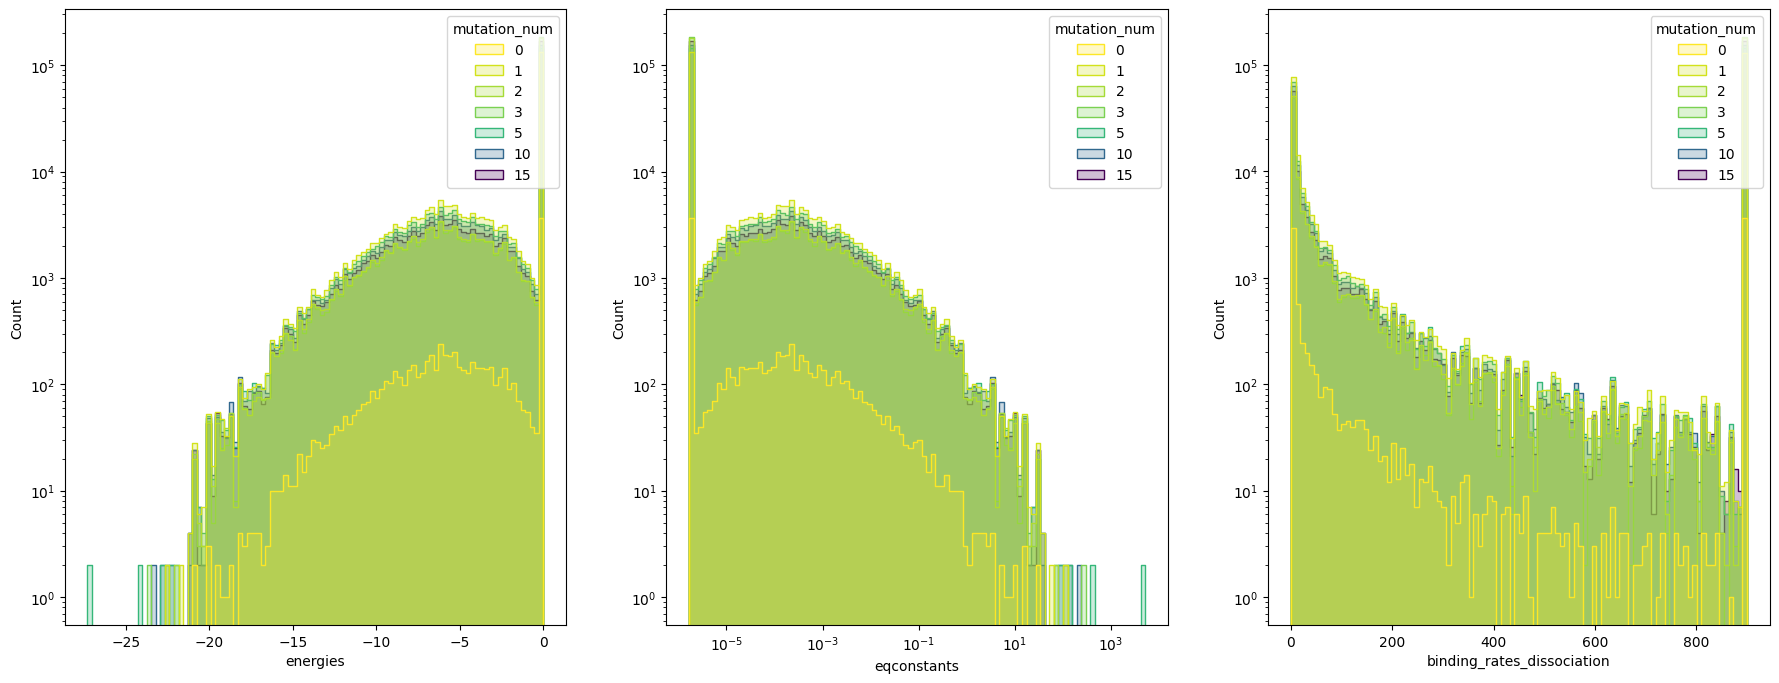

In [8]:

# import seaborn as sns
# sns.histplot = partial(sns.histplot)

plt.figure()
# binding rates by mutation num
# plt.figure(10, 10)
# for i in range(len(circuits[0].get_input_species())):
#     for j in range(i, len(circuits[0].get_input_species())):
#         ax = plt.subplot(len(circuits[0].get_input_species()), len(circuits[0].get_input_species()), i+j+1)
#         sns.histplot(data[data['sample_name'] == 'RNA_0'], x=f'binding_rates_dissociation_{i}-{j}', hue='mutation_num', log_scale=[False, True], element='step')

plt.figure(figsize=(22, 8))
ax = plt.subplot(1,3,1)
sns.histplot(dfm, x='energies', hue='mutation_num', log_scale=[False, True], element='step', bins=100, palette='viridis_r')
ax = plt.subplot(1,3,2)
sns.histplot(dfm, x='eqconstants', hue='mutation_num', log_scale=[True, True], element='step', bins=100, palette='viridis_r')
ax = plt.subplot(1,3,3)
sns.histplot(dfm, x='binding_rates_dissociation', hue='mutation_num', log_scale=[False, True], element='step', bins=100, palette='viridis_r')

# variation within each circuit by mutation num

# variation within each circuit overall
# variation within each circuit overall by fraction of mutations in binding site

Double check conversion from energies to eqconstants.

/var/folders/89/b14m_l9d4h58lnx67_8_2p440000gn/T/ipykernel_30749/3796461029.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=dfm['energies'], log_scale=[False, True], element='step', bins=100, palette='viridis_r')
/var/folders/89/b14m_l9d4h58lnx67_8_2p440000gn/T/ipykernel_30749/3796461029.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=equilibrium_constant_reparameterisation(dfm['energies'], initial = 100), log_scale=[True, True], element='step', bins=100, palette='viridis_r')


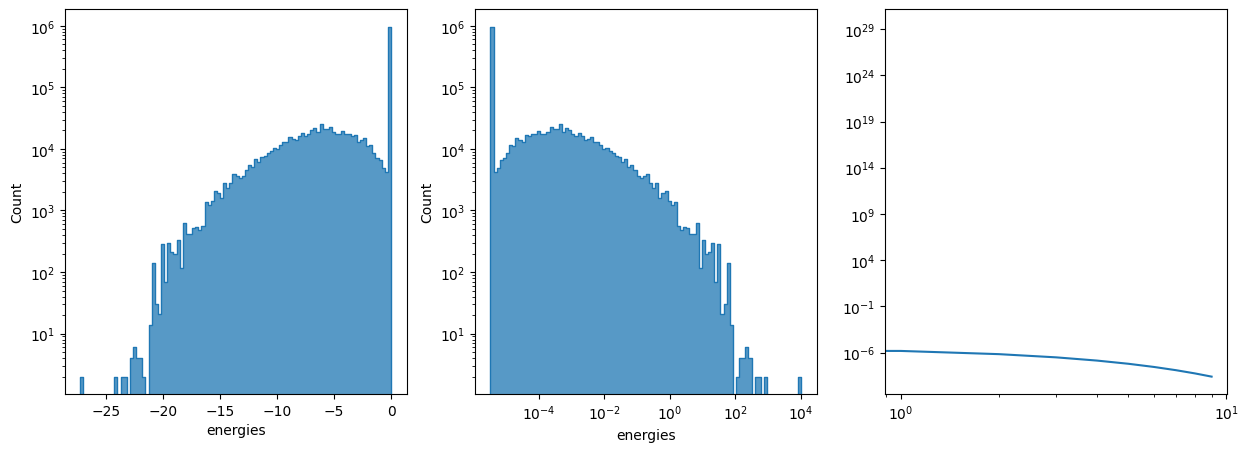

In [52]:

def equilibrium_constant_reparameterisation(E, initial: np.array):
    """ The energy input E is $\Delta G$ in kcal/mol. 
    IMPORTANT: Using the mean initial quantity of all species, as this 
    equation was derived under the assumption that all unbound species 
    start with the same concentration and have the same interactions """
    # return 1/initial * (1/F(E) - 1)
    Fs = np.exp(-0.8 * (E + 10))
    return Fs/initial

plt.figure(figsize=(15, 5))
ax = plt.subplot(1,3,1)
sns.histplot(x=dfm['energies'], log_scale=[False, True], element='step', bins=100, palette='viridis_r')
ax = plt.subplot(1,3,2)
sns.histplot(x=equilibrium_constant_reparameterisation(dfm['energies'], initial = 100), log_scale=[True, True], element='step', bins=100, palette='viridis_r')
ax = plt.subplot(1,3,3)
x = np.arange(-100, 10)
plt.plot(x, equilibrium_constant_reparameterisation(x, initial=100))
plt.xscale('log')
plt.yscale('log')


The fraction of mutations within a binding site is more variable for circuits with fewer mutations, which makes sense since there is a higher chance for fraction values to be extreme at low mutation numbers. The means on the other hand are distributed similarly for all increasing numbers of mutations.

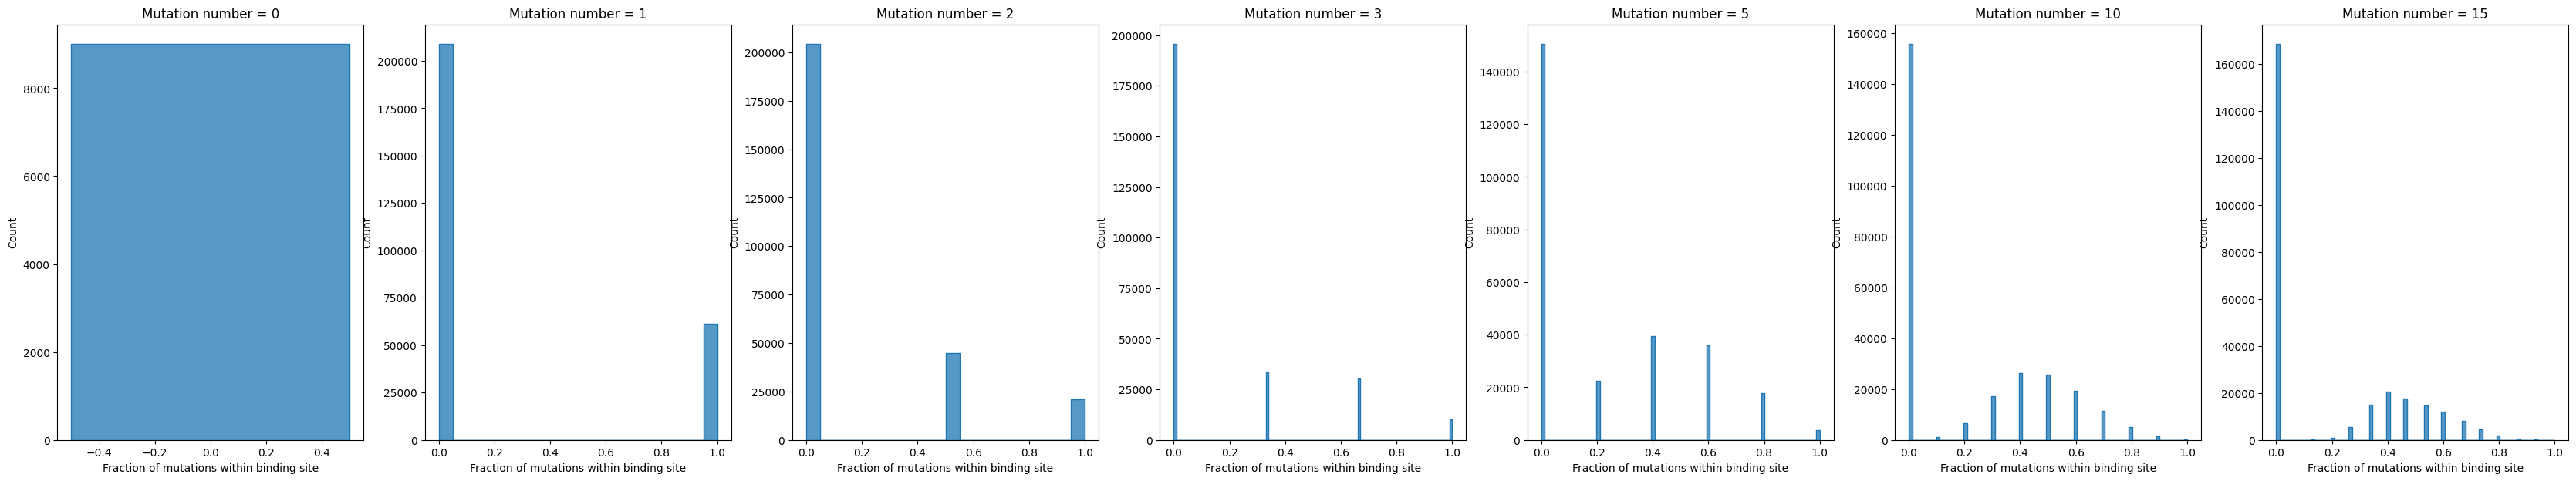

In [7]:
muts = dfm['mutation_num'].unique()
plt.figure(figsize=(6*len(muts), 7))
for i, m in enumerate(muts):
    ax = plt.subplot(1, len(muts), i+1)
    sns.histplot(dfm[dfm['mutation_num'] == m], x='frac_muts_in_binding_site', element='step')
    plt.title(f'Mutation number = {m}')
    plt.xlabel('Fraction of mutations within binding site')

Text(0.5, 0.98, 'Fraction of mutations within binding site')

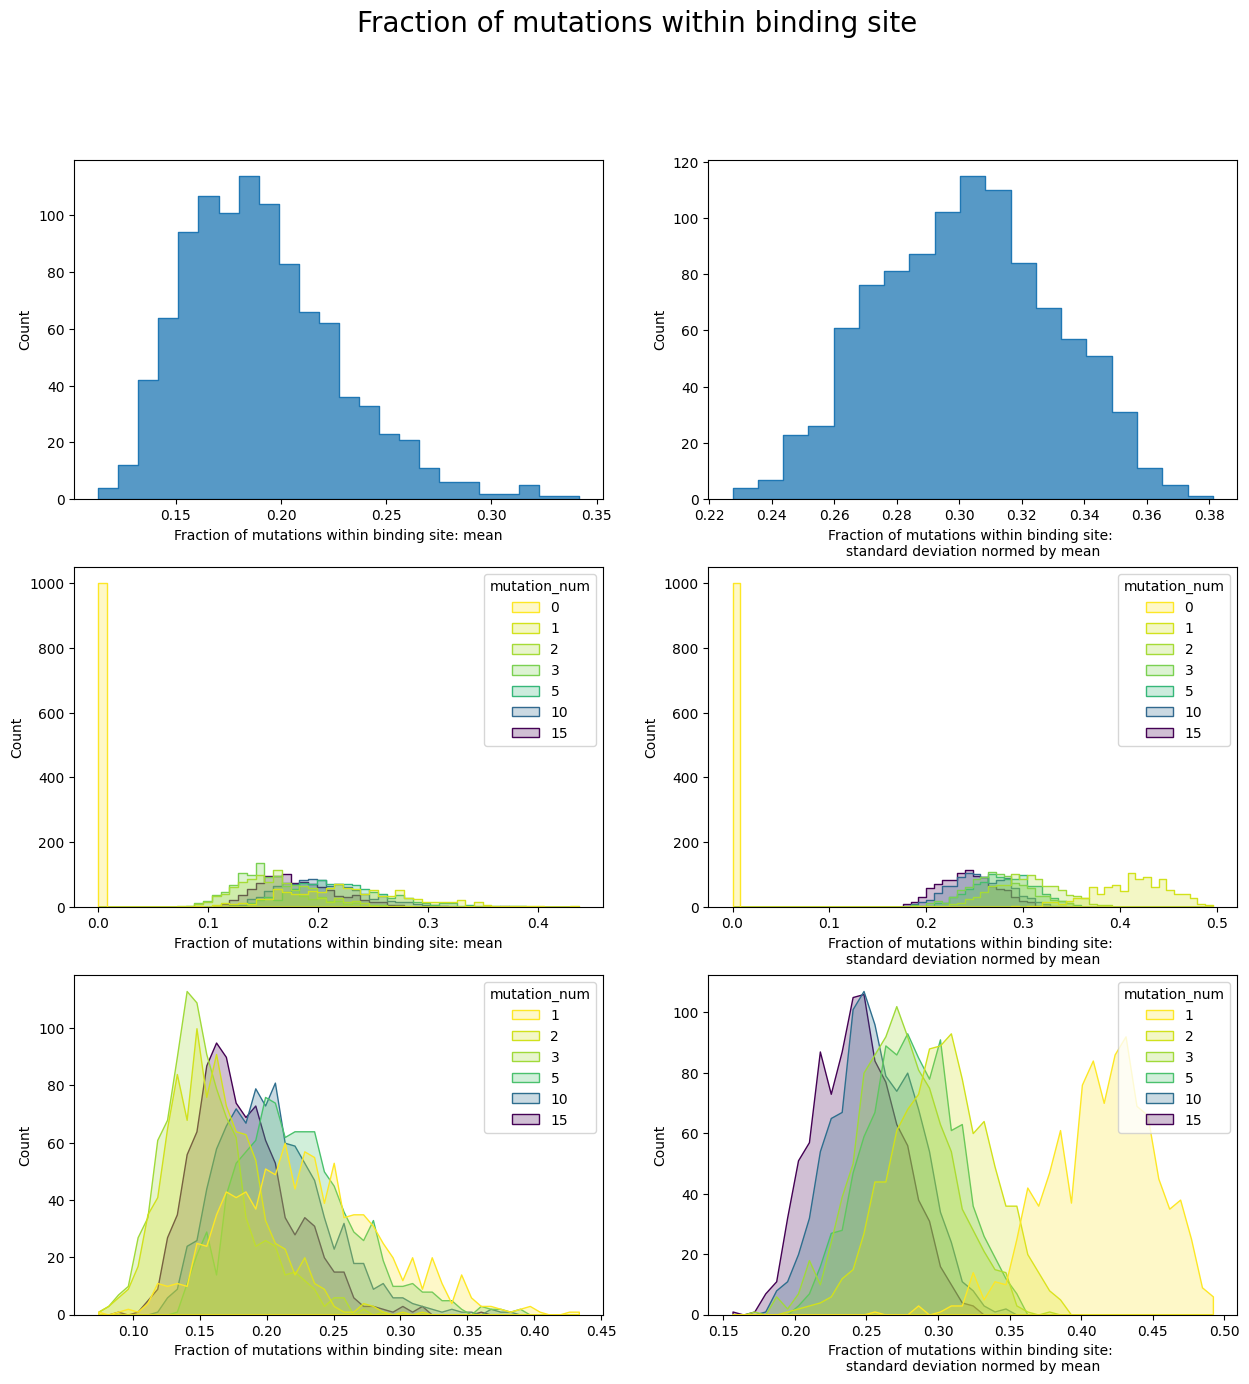

In [8]:

plt.figure(figsize=(15, 15))
ax = plt.subplot(3,2,1)
stds = dfm.groupby(['circuit_name'], as_index=False).agg(
        **{'frac_muts_in_binding_site' + '_std': pd.NamedAgg(column='frac_muts_in_binding_site', aggfunc='std'),
        'frac_muts_in_binding_site' + '_mean': pd.NamedAgg(column='frac_muts_in_binding_site', aggfunc='mean'),
        'frac_muts_in_binding_site' + '_std_normed_by_mean': pd.NamedAgg(column='frac_muts_in_binding_site', aggfunc=lambda x: np.std(x) / np.max([1, np.mean(x)]))})

sns.histplot(stds, x='frac_muts_in_binding_site' + '_mean', log_scale=[False, False], element='step')
plt.xlabel('Fraction of mutations within binding site: mean')

ax = plt.subplot(3,2,2)
sns.histplot(stds, x='frac_muts_in_binding_site' + '_std_normed_by_mean', log_scale=[False, False], element='step')
plt.xlabel('Fraction of mutations within binding site: \nstandard deviation normed by mean')

ax = plt.subplot(3,2,3)
stds = dfm.groupby(['circuit_name', 'mutation_num'], as_index=False).agg(
        **{'frac_muts_in_binding_site' + '_std': pd.NamedAgg(column='frac_muts_in_binding_site', aggfunc='std'),
        'frac_muts_in_binding_site' + '_mean': pd.NamedAgg(column='frac_muts_in_binding_site', aggfunc='mean'),
        'frac_muts_in_binding_site' + '_std_normed_by_mean': pd.NamedAgg(column='frac_muts_in_binding_site', aggfunc=lambda x: np.std(x) / np.max([1, np.mean(x)]))})
sns.histplot(stds, x='frac_muts_in_binding_site' + '_mean', log_scale=[False, False], element='step', hue='mutation_num', palette='viridis_r')
plt.xlabel('Fraction of mutations within binding site: mean')

ax = plt.subplot(3,2,4)
sns.histplot(stds, x='frac_muts_in_binding_site' + '_std_normed_by_mean', log_scale=[False, False], element='step', hue='mutation_num', palette='viridis_r')
plt.xlabel('Fraction of mutations within binding site: \nstandard deviation normed by mean')

ax = plt.subplot(3,2,5)
sns.histplot(stds[stds['mutation_num'] > 0], x='frac_muts_in_binding_site' + '_mean', log_scale=[False, False], element='poly', hue='mutation_num', palette='viridis_r')
plt.xlabel('Fraction of mutations within binding site: mean')

ax = plt.subplot(3,2,6)
sns.histplot(stds[stds['mutation_num'] > 0], x='frac_muts_in_binding_site' + '_std_normed_by_mean', log_scale=[False, False], element='poly', hue='mutation_num', palette='viridis_r')
plt.xlabel('Fraction of mutations within binding site: \nstandard deviation normed by mean')


plt.suptitle('Fraction of mutations within binding site', fontsize=20)


The distribution in the mean fraction of mutations within a binding site follows the distribution of number of interacting species. Though 2 and 3 mutations have the lowest mean distributions overall, thereby the fewest mutations that fall within a binding region, they still have a distribution of interacting species that is skewed towards zero compared to other mutation numbers.

<AxesSubplot: xlabel='num_interacting', ylabel='Count'>

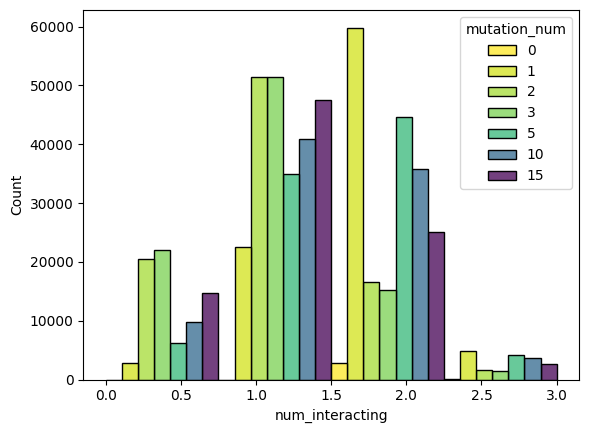

In [10]:
sns.histplot(data, x='num_interacting', hue='mutation_num', multiple='dodge', bins=4, palette='viridis_r')

### Mutation effect on analytics

We will look at how mutations affect the behavior of the circuit by looking at the change in circuit analytics (sensitivity, precision, overshoot, fold change...) and mutation change at the same time. Below, the distribution of sensitivities for all circuits are shown by number of mutations. The distributions are very similar and 

Text(0.5, 0.98, 'Sensitivity across mutations > 0')

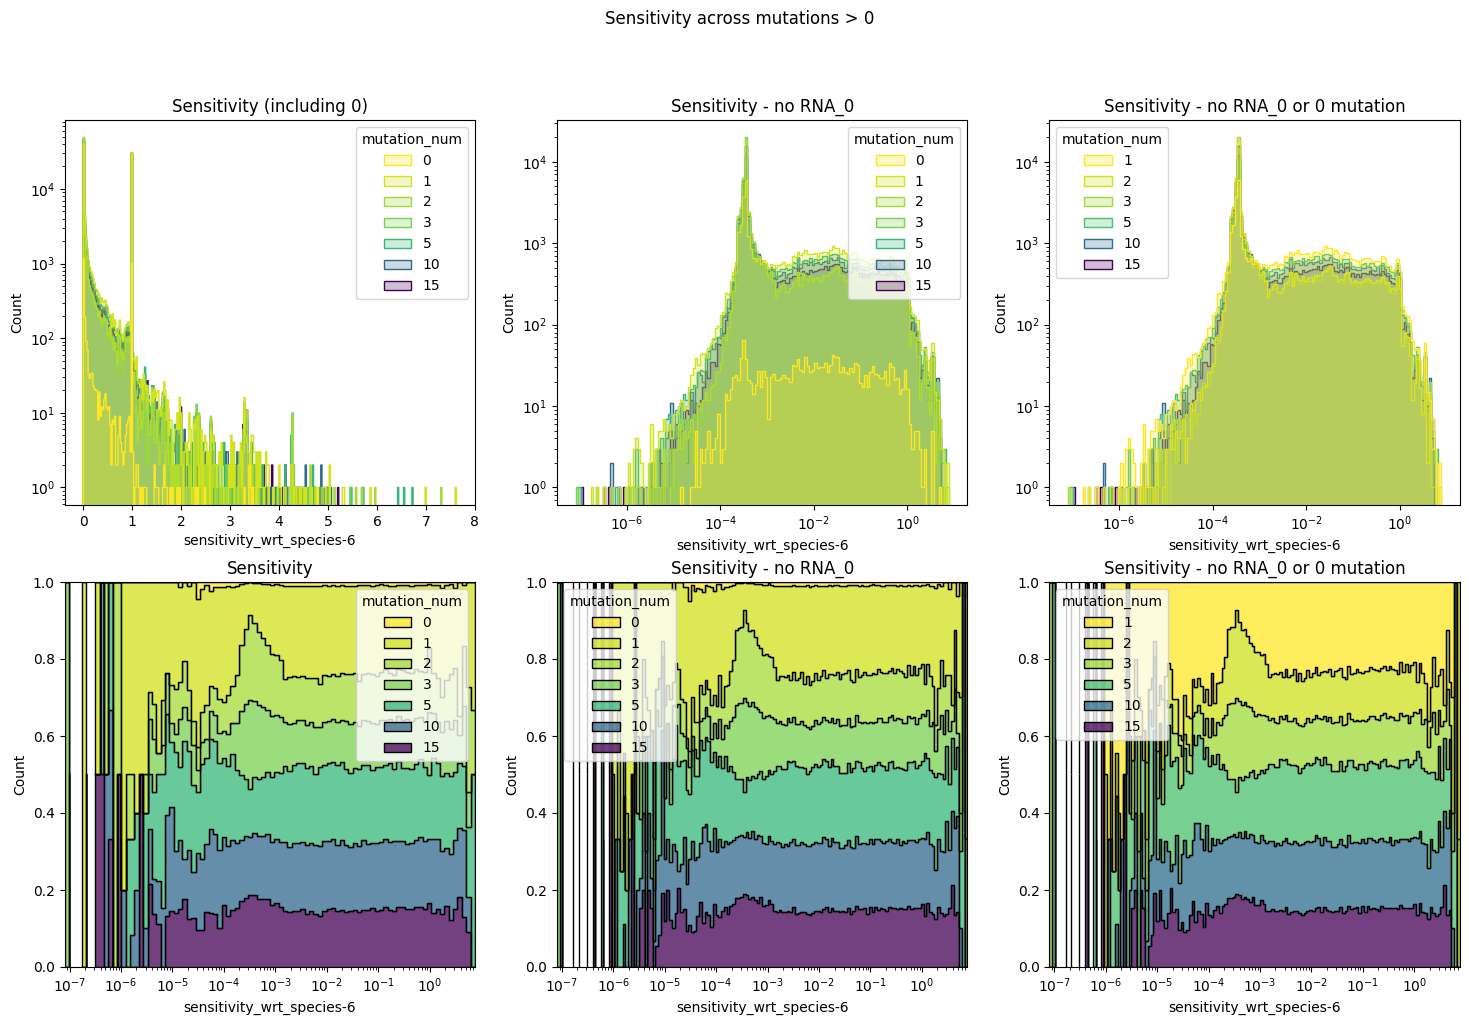

In [61]:
exc_filt = (data['sensitivity_wrt_species-6'] > 0)

plt.figure(figsize=(18,11))

ax = plt.subplot(2,3,1)
sns.histplot(data, x='sensitivity_wrt_species-6', hue='mutation_num', log_scale=[False, True], element='step', palette='viridis_r')
plt.title('Sensitivity (including 0)')
ax = plt.subplot(2,3,2)
sns.histplot(data[(data['sample_name'] != 'RNA_0') & exc_filt], x='sensitivity_wrt_species-6', hue='mutation_num', log_scale=[True, True], element='step', palette='viridis_r')
plt.title('Sensitivity - no RNA_0$$')
ax = plt.subplot(2,3,3)
sns.histplot(data[(data['sample_name'] != 'RNA_0') & (data['mutation_num'] > 0) & exc_filt], x='sensitivity_wrt_species-6', hue='mutation_num', log_scale=[True, True], element='step', palette='viridis_r')
sns.move_legend(ax, "upper left")
plt.title('Sensitivity - no $RNA_0$ or 0 mutation')


ax = plt.subplot(2,3,4)
sns.histplot(data[exc_filt], x='sensitivity_wrt_species-6', hue='mutation_num', log_scale=[True, False], element='step', multiple='fill', palette='viridis_r')
plt.title('Sensitivity')
ax = plt.subplot(2,3,5)
sns.histplot(data[(data['sample_name'] != 'RNA_0') & exc_filt], x='sensitivity_wrt_species-6', hue='mutation_num', log_scale=[True, False], element='step', multiple='fill', palette='viridis_r')
sns.move_legend(ax, "upper left")
plt.title('Sensitivity - no RNA_0$$')
ax = plt.subplot(2,3,6)
sns.histplot(data[(data['sample_name'] != 'RNA_0') & (data['mutation_num'] > 0) & exc_filt], x='sensitivity_wrt_species-6', hue='mutation_num', log_scale=[True, False], multiple='fill', element='step', palette='viridis_r')
sns.move_legend(ax, "upper left")
plt.title('Sensitivity - no $RNA_0$ or 0 mutation')

plt.suptitle('Sensitivity across mutations > 0')

There are some differences in the distributions of signal sensitivity across all circuits as the mutation number increases. For all circuits, there is a peak in sensitivities roughly between $10e^{-3}$ and $10e^{-4}$ in log sensitivity, not including the sensitivity of species $RNA_0$, which would by design have a sensitivity of 1. While circuits with species containing zero and one mutations have sensitivities that are spread out more on either side of this peak, after 2 mutations there seems to be some sort of selection bias breakdown, as 

Text(0.5, 1.0, 'Sensitivity CDF, no $RNA_0$')

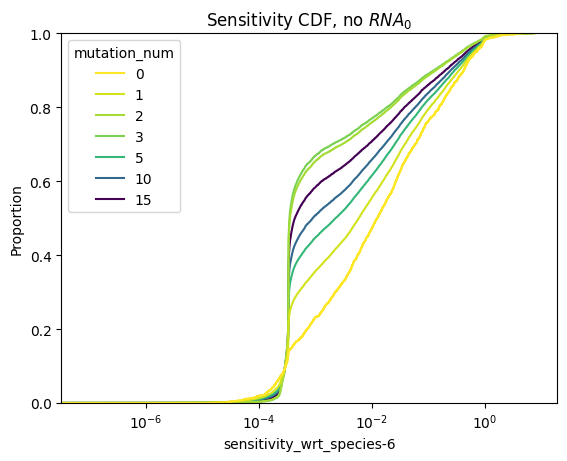

In [56]:
sns.ecdfplot(data[(data['sample_name'] != 'RNA_0')], x='sensitivity_wrt_species-6', hue='mutation_num', log_scale=[False, False], palette='viridis_r')
plt.title('Sensitivity CDF, no $RNA_0$')

The nature of the CDF for each of the different number of mutations, as well as the distribution of the fraction of mutations within binding sites for increasing mutation numbers corresponds to the number of interacting species in each circuit. For the circuits with no mutations (the reference circuits), a selection bias was applied to pre-select for strong starting circuits. After this however, the number of interacting circuits was only based on the computed RNA strengths between RNA species. For circuits where species has 1 to 3 mutations, the number of interacting species became increasingly lower, as seen from the distributions in the plot above. The effect is much more dramatic however compared to circuits with 5 or more mutations. This causes a sort of bimodal distribution in the number of interacting circuits. 

The trend in the number of interacting species, and thereby indirectly also the strength of the circuit, may explain the differences between circuit sensitivity change (by ratio of mutation to reference cirucit) for each mutation number. Rather that following a linear trend, the low to medium mutation numbers have more sensitivity ratios on the extremes of the distribution, while medium to higher mutation numers drop off again on the extremes and are more concentrated at the center of the distributions below. The stacked distribution graphs below the histograms highlight this difference in occupancy of the distribution's range for each mutation number. The order of the traces in the CDF of cirucit sensitivities follows the same pattern as in the distribution of number of interacting species.

Text(0.5, 0.98, 'Sensitivity Ratio across mutations > 0')

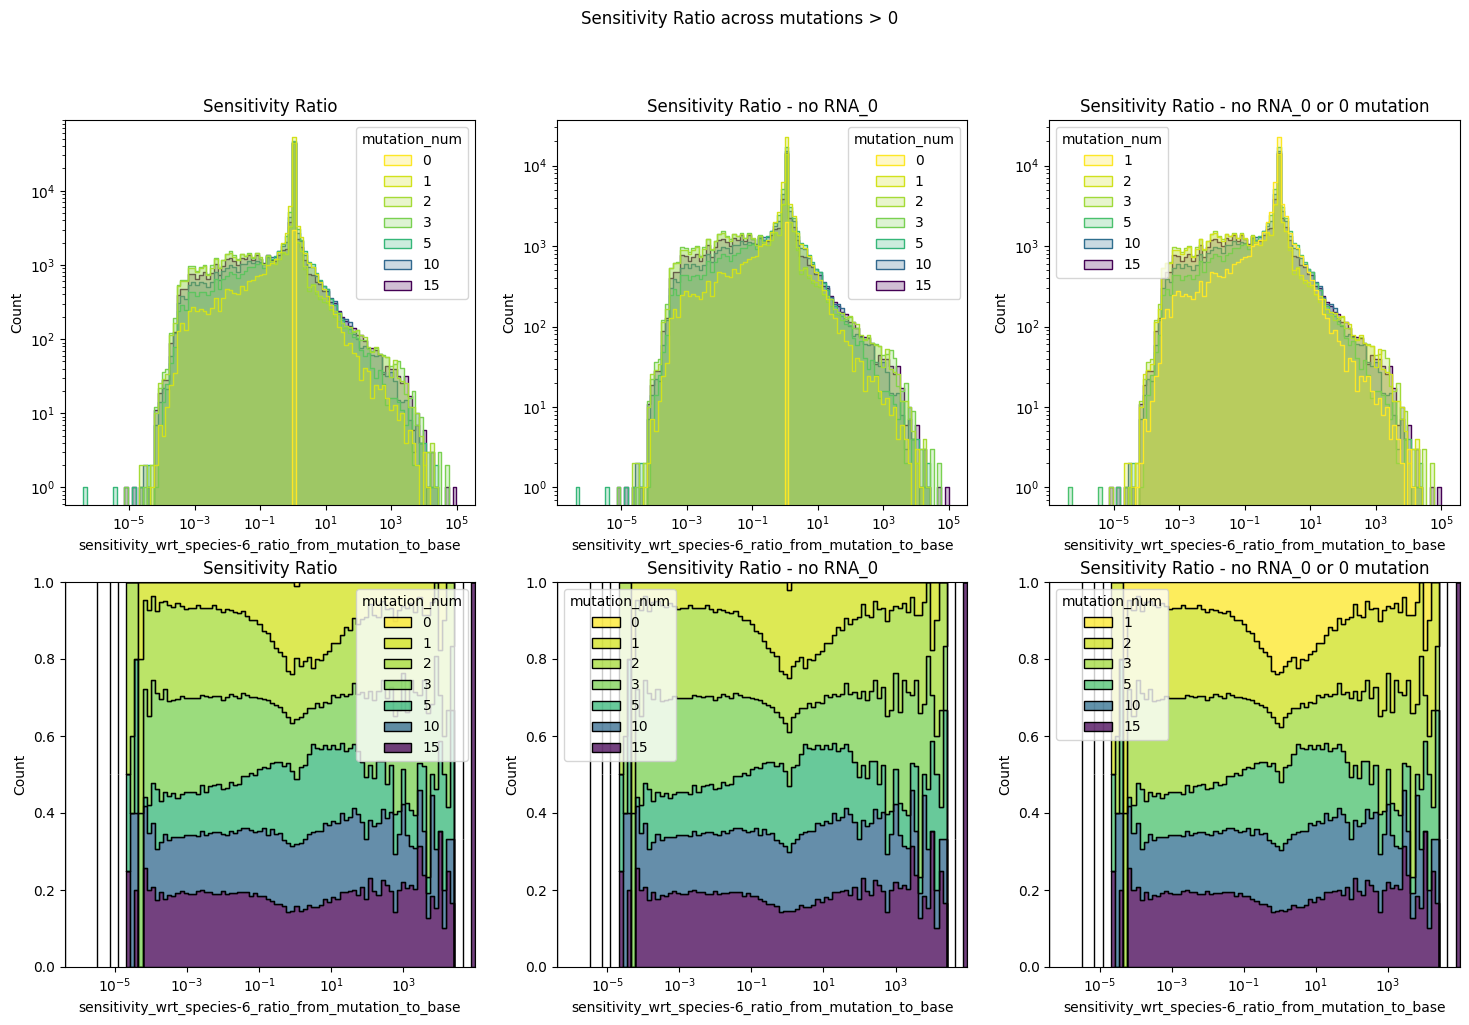

In [43]:
# data['sensitivity_wrt_species-6_diff_to_base_circuit' + '_abs'] = data['sensitivity_wrt_species-6_diff_to_base_circuit'].abs()

gt_filter = (data['sensitivity_wrt_species-6_ratio_from_mutation_to_base' + ''] > 0)

plt.figure(figsize=(18,11))
ax = plt.subplot(2,3,1)
sns.histplot(data[gt_filter], x='sensitivity_wrt_species-6_ratio_from_mutation_to_base' + '', 
            hue='mutation_num', bins=100, log_scale=[True, True], element='step', palette='viridis_r')
plt.title('Sensitivity Ratio')
ax = plt.subplot(2,3,2)
sns.histplot(data[(data['sample_name'] != 'RNA_0') & gt_filter], x='sensitivity_wrt_species-6_ratio_from_mutation_to_base' + '', 
            hue='mutation_num', bins=100, log_scale=[True, True], element='step', palette='viridis_r')
plt.title('Sensitivity Ratio - no RNA_0')
ax = plt.subplot(2,3,3)
sns.histplot(data[(data['sample_name'] != 'RNA_0') & (data['mutation_num'] > 0) & gt_filter], x='sensitivity_wrt_species-6_ratio_from_mutation_to_base' + '', 
            hue='mutation_num', bins=100, log_scale=[True, True], element='step', fill=True, palette='viridis_r')
sns.move_legend(ax, "upper left")
plt.title('Sensitivity Ratio - no RNA_0 or 0 mutation')


ax = plt.subplot(2,3,4)
sns.histplot(data[gt_filter], x='sensitivity_wrt_species-6_ratio_from_mutation_to_base' + '', 
            hue='mutation_num', bins=100, log_scale=[True, False], element='step', palette='viridis_r', multiple='fill')
plt.title('Sensitivity Ratio')
ax = plt.subplot(2,3,5)
sns.histplot(data[(data['sample_name'] != 'RNA_0') & gt_filter], x='sensitivity_wrt_species-6_ratio_from_mutation_to_base' + '', 
            hue='mutation_num', bins=100, log_scale=[True, False], element='step', palette='viridis_r', multiple='fill')
sns.move_legend(ax, "upper left")
plt.title('Sensitivity Ratio - no RNA_0')
ax = plt.subplot(2,3,6)
sns.histplot(data[(data['sample_name'] != 'RNA_0') & (data['mutation_num'] > 0) & gt_filter], x='sensitivity_wrt_species-6_ratio_from_mutation_to_base' + '', 
            hue='mutation_num', bins=100, log_scale=[True, False], multiple='fill', element='step', fill=True, palette='viridis_r')
sns.move_legend(ax, "upper left")
plt.title('Sensitivity Ratio - no RNA_0 or 0 mutation')

plt.suptitle('Sensitivity Ratio across mutations > 0')

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Sensitivity ratio CDF, no $RNA_0$')

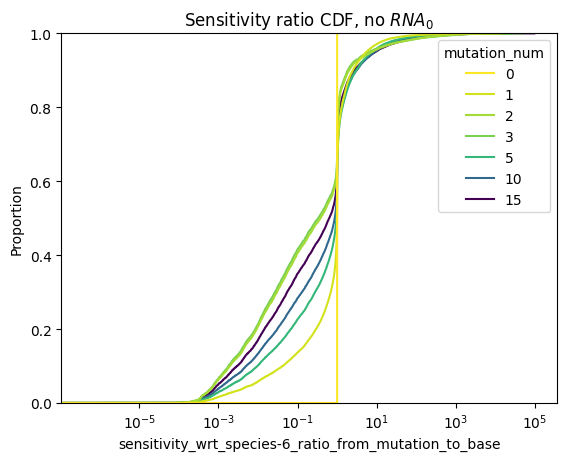

In [60]:
sns.ecdfplot(data[(data['sample_name'] != 'RNA_0')], x='sensitivity_wrt_species-6_ratio_from_mutation_to_base', hue='mutation_num', log_scale=[True, False], palette='viridis_r')
plt.title('Sensitivity ratio CDF, no $RNA_0$')

### Compare to random

For some reason, there is a weird drop in the number of strong circuits at 2-3 mutations.

In [76]:
m = dfm.groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_other = dfm[dfm['num_self_interacting'] == 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_self = dfm[dfm['num_interacting'] == 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_both = dfm[(dfm['num_interacting'] > 0) & (dfm['num_self_interacting'] > 0)].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})

In [77]:
m2 = dfm[dfm['energies'] < 0].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_other2 = dfm[(dfm['num_self_interacting'] == 0) & (dfm['energies'] < 0)].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_self2 = dfm[(dfm['num_interacting'] == 0) & (dfm['energies'] < 0)].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_both2 = dfm[(dfm['num_interacting'] > 0) & (dfm['num_self_interacting'] > 0) & (dfm['energies'] < 0)].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})


In [80]:
null_circs = dfm[(dfm['mutation_name'] == 'ref_circuit') & (dfm['energies'] == 0)]['circuit_name'].unique()

In [82]:
m0 = dfm[dfm['circuit_name'].isin(null_circs)].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_other0 = dfm[(dfm['num_self_interacting'] == 0) & (dfm['circuit_name'].isin(null_circs))].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_self0 = dfm[(dfm['num_interacting'] == 0) & (dfm['circuit_name'].isin(null_circs))].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_both0 = dfm[(dfm['num_interacting'] > 0) & (dfm['num_self_interacting'] > 0) & (dfm['circuit_name'].isin(null_circs))].groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})


In [85]:
dfm[(dfm['mutation_name'] == 'ref_circuit') & (dfm['energies'] == 0)]



,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,name,interacting,self_interacting,num_interacting,...,binding_rates_dissociation_diffs,binding_rates_dissociation_diffs_logm,eqconstants_diffs,eqconstants_diffs_logm,energies_diffs,energies_diffs_logm,num_muts_in_binding_site,num_muts_in_binding_site_edge,frac_muts_in_binding_site,frac_muts_in_binding_site_edge
0,toy_circuit_combo0_100572,ref_circuit,0,[],[],NaN,toy_circuit_combo0_100572,[[0 2]\n [1 2]],[[2 2]],2,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0.0,0.0
1,toy_circuit_combo0_100572,ref_circuit,0,[],[],NaN,toy_circuit_combo0_100572,[[0 2]\n [1 2]],[[2 2]],2,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0.0,0.0
2,toy_circuit_combo0_100572,ref_circuit,0,[],[],NaN,toy_circuit_combo0_100572,[[0 2]\n [1 2]],[[2 2]],2,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0.0,0.0
2715,toy_circuit_combo0_105905,ref_circuit,0,[],[],NaN,toy_circuit_combo0_105905,[[0 1]\n [0 2]],[[1 1]\n [2 2]],2,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0.0,0.0
2716,toy_circuit_combo0_105905,ref_circuit,0,[],[],NaN,toy_circuit_combo0_105905,[[0 1]\n [0 2]],[[1 1]\n [2 2]],2,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4885372,toy_circuit_combo0_997282,ref_circuit,0,[],[],NaN,toy_circuit_combo0_997282,[[0 1]\n [0 2]],[[1 1]],2,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0.0,0.0
4885373,toy_circuit_combo0_997282,ref_circuit,0,[],[],NaN,toy_circuit_combo0_997282,[[0 1]\n [0 2]],[[1 1]],2,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0.0,0.0
4886457,toy_circuit_combo0_999201,ref_circuit,0,[],[],NaN,toy_circuit_combo0_999201,[[0 2]\n [1 2]],[[0 0]],2,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0.0,0.0
4886458,toy_circuit_combo0_999201,ref_circuit,0,[],[],NaN,toy_circuit_combo0_999201,[[0 2]\n [1 2]],[[0 0]],2,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0.0,0.0


Text(0.5, 1.0, 'Reference circuit binding energy == 0')

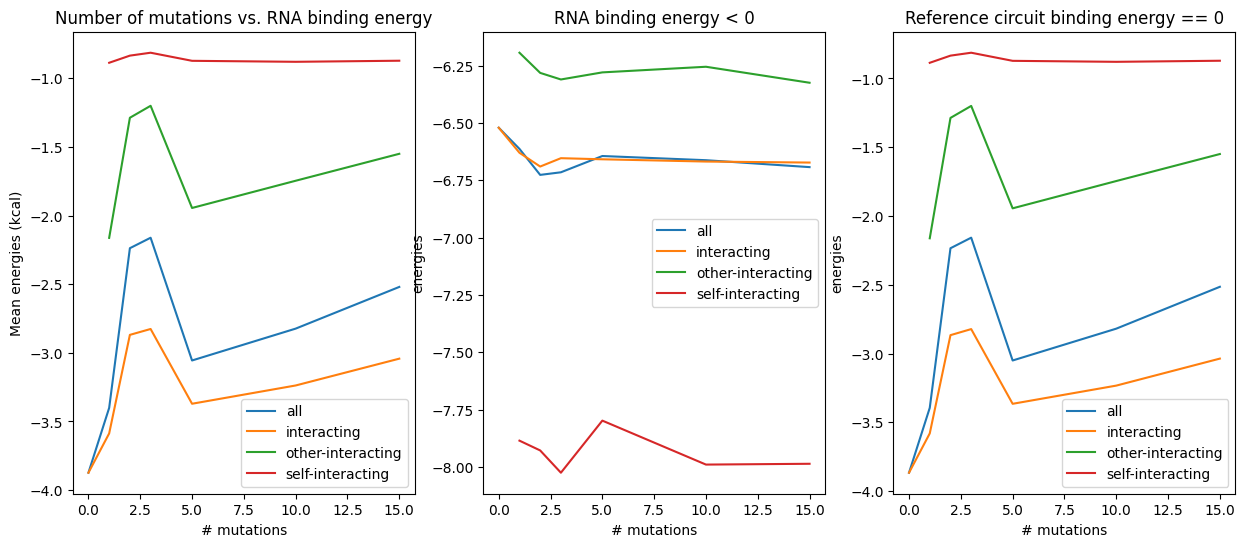

In [83]:
plt.figure(figsize=(20, 6))

ax = plt.subplot(1,3,1)
sns.lineplot(m, x='mutation_num', y='energies', label='all', legend='full')
sns.lineplot(m_both, x='mutation_num', y='energies', label='interacting', legend='full')
sns.lineplot(m_other, x='mutation_num', y='energies', label='other-interacting', legend='full')
sns.lineplot(m_self, x='mutation_num', y='energies', label='self-interacting', legend='full')

plt.ylabel('Mean energies (kcal)')
plt.xlabel('# mutations')
plt.title('Number of mutations vs. RNA binding energy')

ax = plt.subplot(1,3,2)
sns.lineplot(m2, x='mutation_num', y='energies', label='all', legend='full')
sns.lineplot(m_both2, x='mutation_num', y='energies', label='interacting', legend='full')
sns.lineplot(m_other2, x='mutation_num', y='energies', label='other-interacting', legend='full')
sns.lineplot(m_self2, x='mutation_num', y='energies', label='self-interacting', legend='full')

# plt.ylabel('Mean energies (kcal)')
plt.xlabel('# mutations')
plt.title('RNA binding energy < 0')

ax = plt.subplot(1,3,3)
sns.lineplot(m0, x='mutation_num', y='energies', label='all', legend='full')
sns.lineplot(m_both0, x='mutation_num', y='energies', label='interacting', legend='full')
sns.lineplot(m_other0, x='mutation_num', y='energies', label='other-interacting', legend='full')
sns.lineplot(m_self0, x='mutation_num', y='energies', label='self-interacting', legend='full')

# plt.ylabel('Mean energies (kcal)')
plt.xlabel('# mutations')
plt.title('Reference circuit binding energy == 0')

### Beneficial mutations

Investigating effect of specific mutations

In [48]:
del dfm
dfm = melt(data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)

/home/wadh6511/Kode/gene-circuit-glitch-prediction/explanations/data_enhancing.py:121: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  infom[f'{k}_diffs'] = info.groupby(['circuit_name'])[get_true_interaction_cols2(info, k)].apply(
/home/wadh6511/Kode/gene-circuit-glitch-prediction/explanations/data_enhancing.py:123: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and

In [27]:
dfm[(dfm['sensitivity_wrt_species-6_ratio_from_mutation_to_base'] > 1) & (dfm['precision_wrt_species-6_ratio_from_mutation_to_base'] > 1)]


,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,name,interacting,self_interacting,num_interacting,...,binding_rates_dissociation_diffs,binding_rates_dissociation_diffs_logm,eqconstants_diffs,eqconstants_diffs_logm,energies_diffs,energies_diffs_logm,num_muts_in_binding_site,num_muts_in_binding_site_edge,frac_muts_in_binding_site,frac_muts_in_binding_site_edge
547,toy_circuit_combo0_10360,RNA_0_m1-0,1,[4],[18],data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_10360,[[0 1]\n [1 2]],[[0 0]],2,...,-7.367751,-4.328,0.015122,4.328,-5.41,0.643522,1,0,1.000000,0.000000
727,toy_circuit_combo0_10360,RNA_1_m1-0,1,[10],[19],data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_10360,[[0 1]\n [1 2]],[[0 0]],2,...,0.000000,0.000,0.000000,0.000,0.00,0.000000,0,0,0.000000,0.000000
1066,toy_circuit_combo0_10360,RNA_2_m15-3,15,"[4, 7, 11, 4, 1, 4, 6, 5, 0, 11, 3, 4, 11, 10, 2]","[12, 4, 5, 16, 10, 17, 1, 14, 18, 9, 19, 15, 6...",data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_10360,[[0 1]\n [1 2]],[[0 0]\n [2 2]],2,...,0.000000,0.000,0.000000,0.000,0.00,0.000000,4,1,0.266667,0.066667
1196,toy_circuit_combo0_104210,RNA_0_m5-5,5,"[4, 10, 11, 2, 7]","[3, 8, 7, 13, 11]",data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_104210,[[0 1]\n [0 2]],[[0 0]],2,...,-200.004009,-9.776,0.132871,9.776,-12.22,2.014903,4,0,0.800000,0.000000
1490,toy_circuit_combo0_104210,RNA_2_m2-3,2,"[0, 6]","[1, 17]",data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_104210,[[0 1]\n [0 2]],[[0 0]\n [2 2]],2,...,0.000000,0.000,0.000000,0.000,0.00,0.000000,1,1,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4885933,toy_circuit_combo0_998339,RNA_0_m1-5,1,[9],[9],data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_998339,[[0 2]\n [1 2]],[[1 1]\n [2 2]],2,...,0.000000,0.000,0.000000,0.000,0.00,0.000000,1,0,1.000000,0.000000
4886125,toy_circuit_combo0_998339,RNA_1_m1-9,1,[10],[7],data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_998339,[[0 2]\n [1 2]],[[1 1]\n [2 2]],2,...,0.000000,0.000,0.000000,0.000,0.00,0.000000,1,0,1.000000,0.000000
4886187,toy_circuit_combo0_998339,RNA_1_m5-0,5,"[6, 6, 0, 9, 4]","[8, 3, 16, 7, 12]",data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_998339,[[0 2]\n [1 2]],[[1 1]\n [2 2]],2,...,0.000000,0.000,0.000000,0.000,0.00,0.000000,3,1,0.600000,0.200000
4886268,toy_circuit_combo0_998339,RNA_1_m15-7,15,"[2, 4, 5, 7, 3, 8, 10, 5, 7, 10, 7, 11, 6, 6, 6]","[16, 6, 0, 2, 1, 8, 18, 12, 11, 7, 3, 4, 19, 1...",data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_998339,[[0 2]\n [1 2]],[[2 2]],2,...,0.000000,0.000,0.000000,0.000,0.00,0.000000,6,2,0.400000,0.133333


In [29]:
sns.histplot(dfm, x='sensitivity_wrt_species-6_ratio_from_mutation_to_base', log_scale=[False, True])

In [ ]:
sns.scatterplot(dfm, x='sensitivity_wrt_species-6_ratio_from_mutation_to_base', hue='num_muts_in_binding_site')
